# Project Group 10
<br>Name: Abhilash Narayanan
<br>ID: 49078178

In [122]:
install.packages("tidyverse")
install.packages("cluster")
install.packages("factoextra")
install.packages("dbscan")
install.packages("funtimes")
install.packages("clValid")
install.packages("e1071")

Warning message:
"package 'tidyverse' is in use and will not be installed"
Warning message:
"package 'cluster' is in use and will not be installed"
Warning message:
"package 'factoextra' is in use and will not be installed"
Warning message:
"package 'dbscan' is in use and will not be installed"
Warning message:
"package 'funtimes' is in use and will not be installed"
Installing package into 'C:/Users/nilee/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'clValid' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\nilee\AppData\Local\Temp\RtmpaWxXgL\downloaded_packages


Warning message:
"package 'e1071' is in use and will not be installed"


In [123]:
library("tidyverse")
library("ggplot2")
library("ggrepel")
library("ggcorrplot")
library("DT")
library("cluster")
library("factoextra")
library("funtimes")
install.packages("clValid")
library("e1071")

Installing package into 'C:/Users/nilee/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'clValid' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\nilee\AppData\Local\Temp\RtmpaWxXgL\downloaded_packages


In [124]:
dataset_plus_census <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")
#filter the dataset by Texas
dataset_plus_census <- dataset_plus_census %>% filter(state == "TX")


## Excluding counties of the major cities

In [125]:
counties_to_exclude <- c(
  "Dallas County", "Tarrant County", "Collin County", "Denton County", "Ellis County",
  "Johnson County", "Kaufman County", "Parker County", "Rockwall County", "Wise County",
  "Hood County", "Travis County", "Williamson County", "Hays County", "Bastrop County",
  "Caldwell County", "Bexar County", "Comal County", "Guadalupe County", "Wilson County",
  "Medina County", "Kendall County", "Bandera County", "Atascosa County", "Harris County",
  "Fort Bend County", "Montgomery County", "Brazoria County", "Galveston County", "Liberty County",
  "Waller County", "Chambers County"
)

dataset_plus_census <- dataset_plus_census %>% 
  filter(! county_name %in% counties_to_exclude)

In [126]:
head(dataset_plus_census)
summary(dataset_plus_census)

,state,state_fips_code,county_name,confirmed_cases,deaths,total_pop,male_pop,female_pop,white_pop,black_pop,⋯,male_21_49,male_50_above,female_0_20,female_21_49,female_50_above,unemployed_pop,employed_pop,commute,worked_at_home,walked_to_work
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,TX,48,Hansford County,673,17,5532,2760,2772,2950,4,⋯,1052,922,858,1053,979,94,2394,4384,18,70
2,TX,48,Stonewall County,134,4,1084,555,529,787,38,⋯,113,325,129,112,306,11,442,836,7,0
3,TX,48,Cochran County,216,12,2932,1492,1440,1104,77,⋯,418,536,420,538,548,103,1189,2274,23,12
4,TX,48,Crockett County,472,13,3836,1903,1933,1264,35,⋯,512,748,584,662,738,43,1733,3346,60,0
5,TX,48,McCulloch County,467,12,8145,4171,3974,5067,161,⋯,1354,1765,911,1334,1885,122,3658,6566,61,104
6,TX,48,Sherman County,118,11,3067,1590,1477,1712,8,⋯,582,594,398,577,555,24,1604,2930,38,72


    state           state_fips_code county_name        confirmed_cases 
 Length:222         Min.   :48      Length:222         Min.   :     1  
 Class :character   1st Qu.:48      Class :character   1st Qu.:   436  
 Mode  :character   Median :48      Mode  :character   Median :  1077  
                    Mean   :48                         Mean   :  3619  
                    3rd Qu.:48                         3rd Qu.:  2544  
                    Max.   :48                         Max.   :107552  
     deaths          total_pop         male_pop        female_pop    
 Min.   :   0.00   Min.   :    74   Min.   :    39   Min.   :    35  
 1st Qu.:  12.00   1st Qu.:  5790   1st Qu.:  2894   1st Qu.:  2700  
 Median :  25.50   Median : 14448   Median :  7355   Median :  6766  
 Mean   :  77.73   Mean   : 42474   Mean   : 21230   Mean   : 21243  
 3rd Qu.:  61.75   3rd Qu.: 34990   3rd Qu.: 17795   3rd Qu.: 17256  
 Max.   :2018.00   Max.   :839539   Max.   :410383   Max.   :429156  
   whi

# Hierarchical Clustering

Hierarchical clustering is an alternative approach to for identifying groups in the dataset. It does not require us to pre-specify the number of clusters to be generated. Furthermore, hierarchical clustering has an added advantage that it results in an attractive tree-based representation of the observations, called a dendrogram.

## Creating the Dataset for Hierarchical Clustering

In [127]:
dataset_select_clustering <- dataset_plus_census %>% 
 # filter(confirmed_cases > 100) %>% 
  arrange(desc(confirmed_cases)) %>%    
  select(county_name, confirmed_cases, deaths, total_pop, median_income,median_age, commute,income_50K_100K,black_pop,white_pop,hispanic_pop,
worked_at_home,
walked_to_work
,income_150K_more
,income_100K_150K
,income_less_50K
        ,employed_pop,unemployed_pop)
dataset_select_clustering <- dataset_select_clustering %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases,
commute_1000=commute/total_pop*1000,
worked_at_home_1000=worked_at_home/total_pop*1000,
    walked_to_work_1000=walked_to_work/total_pop*1000,
    employed_pop_1000=employed_pop/total_pop*1000,
    unemployed_pop_1000=unemployed_pop/total_pop*1000
)

summary(dataset_select_clustering)                                               

 county_name        confirmed_cases      deaths          total_pop     
 Length:222         Min.   :     1   Min.   :   0.00   Min.   :    74  
 Class :character   1st Qu.:   436   1st Qu.:  12.00   1st Qu.:  5790  
 Mode  :character   Median :  1077   Median :  25.50   Median : 14448  
                    Mean   :  3619   Mean   :  77.73   Mean   : 42474  
                    3rd Qu.:  2544   3rd Qu.:  61.75   3rd Qu.: 34990  
                    Max.   :107552   Max.   :2018.00   Max.   :839539  
 median_income     median_age       commute       income_50K_100K  
 Min.   :24794   Min.   :25.80   Min.   :    66   Min.   :   19.0  
 1st Qu.:41537   1st Qu.:34.67   1st Qu.:  4344   1st Qu.:  534.8  
 Median :46412   Median :39.20   Median :  9925   Median : 1427.5  
 Mean   :47428   Mean   :39.31   Mean   : 32754   Mean   : 4176.5  
 3rd Qu.:52295   3rd Qu.:43.27   3rd Qu.: 26827   3rd Qu.: 3627.0  
 Max.   :80938   Max.   :57.50   Max.   :647479   Max.   :74071.0  
   black_pop        

## Scaling the data set and calculating the distance 

The below features are selected for the hierarchical clustering: <br>
median_income
<br>median_age
<br>commute_1000
<br>black_pop
<br>white_pop
<br>hispanic_pop

In [128]:
dataset_select_clustering_scale <-scale(dataset_select_clustering[,c("median_income","median_age","commute_1000",
                                                                     "black_pop","white_pop","hispanic_pop")])
summary(dataset_select_clustering_scale)

 median_income       median_age        commute_1000        black_pop       
 Min.   :-2.2682   Min.   :-2.20750   Min.   :-2.81045   Min.   :-0.36496  
 1st Qu.:-0.5904   1st Qu.:-0.75695   1st Qu.:-0.61096   1st Qu.:-0.35884  
 Median :-0.1018   Median :-0.01737   Median : 0.09711   Median :-0.31149  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.4878   3rd Qu.: 0.64865   3rd Qu.: 0.64486   3rd Qu.:-0.06871  
 Max.   : 3.3582   Max.   : 2.97362   Max.   : 3.45757   Max.   : 9.15558  
   white_pop          hispanic_pop    
 Min.   :-0.642387   Min.   :-0.2510  
 1st Qu.:-0.554748   1st Qu.:-0.2321  
 Median :-0.379400   Median :-0.2031  
 Mean   : 0.000000   Mean   : 0.0000  
 3rd Qu.:-0.003394   3rd Qu.:-0.1235  
 Max.   : 4.994073   Max.   : 9.7590  

## Identifying which linkage method can be used for this dataset

**Complete linkage clustering:**<br>It computes all pairwise dissimilarities between the elements in cluster 1 and the elements in cluster 2, and considers the largest value (i.e., maximum value) of these dissimilarities as the distance between the two clusters. It tends to produce more compact clusters.
<br>
**Single linkage clustering:** 
It computes all pairwise dissimilarities between the elements in cluster 1 and the elements in cluster 2, and considers the smallest of these dissimilarities as a linkage criterion. It tends to produce long, “loose” clusters.
<br>
**Mean or average linkage clustering:** 
It computes all pairwise dissimilarities between the elements in cluster 1 and the elements in cluster 2, and considers the average of these dissimilarities as the distance between the two clusters.
<br>
**Ward’s minimum variance method:**
It minimizes the total within-cluster variance. At each step the pair of clusters with minimum between-cluster distance are merged.

In [129]:
agnes(dataset_select_clustering_scale, method = "complete",trace.lev=0)

Call:	 agnes(x = dataset_select_clustering_scale, method = "complete", trace.lev = 0) 
Agglomerative coefficient:  0.9422264 
Order of objects:
  [1]   1   2   3   8   7  12   6  13  14  17   4   5  21  95  65  99  83 131
 [19]  87 134 113 137 125 157  22 105 136 219  69  23  29  70  89 101  97  47
 [37] 107  85 153  55 191 114 203  94 155 170 214 156 165 188 145 163  30  32
 [55]  40  48  44  61  62  54  59  58  86  34  45  49  56  72  84 115 152 209
 [73] 119 154 185 181 216 196  77 108 146 208 116 142 129 151 175 126 123 173
 [91] 195 128 141 161 186 217 201 117 150 174 189 182  79 192 199 122 178 162
[109] 187  82 139 111 159 149 183 144 197 147 168 204 193 176 200 132 207  10
[127]  39  35  20  24  38  31  15  19  27  33  16  18  25  37  51  90  93 100
[145]  50  53  57 104  73 103 110 106 167 112 127 124  78 206  41  60 120 160
[163]  66 164  26  28  68  43  75 130  52 138 194  91 118 171 213  36  96 143
[181]  63 184  92  42  46  67  71  76 102 109 140 221  64  80 212  74 179 21

In [130]:
agnes(dataset_select_clustering_scale, method = "ward",trace.lev=0)

Call:	 agnes(x = dataset_select_clustering_scale, method = "ward", trace.lev = 0) 
Agglomerative coefficient:  0.9702966 
Order of objects:
  [1]   1   2   4   5   3   8   7  12   6  13  14  15  16  18  19  27  33  17
 [19]  25  37  10  39  24  38  35  20  31  23  29   9  11  21  65  99  95  26
 [37]  28  43  75 130  83 131  87 134  36  63 184  92  96 143  72  84 115 144
 [55] 197 152 209 119 154 185  52 138 194  91 118 147 171 213  79 192 199 111
 [73] 159 182 122 178 162 187  41  68  46  67  60 120 160 109 140  42  50  53
 [91]  71  76 102  57 104  66 164  78 206 221  51  90  93 100 106 167  64  80
[109] 112 127 124  73 103 110  88 135 205 169 177 222  81 148 166 172 190 198
[127]  98 121 133 158 180 210 202 218 220 215  22  69 105 136 219  97 113 137
[145] 125 157 145 163  47 107  85 153  55 191 114 203  30  32  40  48  44  61
[163]  62  54  59  34  45  49  56  58  70  89 101  77 108 149 183  82 139  86
[181] 123 173 195 128 141 161 117 150 174 189  94 155 170 214 156 165 188  74
[1

In [131]:
agnes(dataset_select_clustering_scale, method = "single",trace.lev=0)

Call:	 agnes(x = dataset_select_clustering_scale, method = "single", trace.lev = 0) 
Agglomerative coefficient:  0.8757889 
Order of objects:
  [1]   1   2   3   8   7  12  10  21  26  28  44  61  62  59  82 139 108 123
 [19] 144 149 183 197 195 173 146 208 128 141  52 138 194  75 130  91 118 147
 [37] 171 111 159 213  77 116 142 129 151 175  72  84 115  92  96 143 209 161
 [55]  86 168  36  71  76 102  53  54  57 104  73 103 110 112 127 124 152  93
 [73] 100 106 169  63 184 140  58  89 101 186 217 201 181 216  30  32  40  85
 [91] 153  43  46  67  60 120 109 126 119 154 185  65  83  87 134 131  99  48
[109] 211  79 122 178 162 187 192 199 167  51  90 204  95 193  80 121 133 158
[127] 172 190 198  45 177 160 117 174 189 150 113 137 125 157  70 105 136 219
[145]  42  66 135  81 148 166 182  97 164  50 205 210  64  29  24  38  88  23
[163]  47 107  94 196 155 170 156 165 188  49  27  33  98  78  69  37  68  41
[181]  74 179 212 214  22  39  34 176 200  56  55 114 203 191 206  25  18 132


In [132]:
agnes(dataset_select_clustering_scale, method = "average",trace.lev=0)

Call:	 agnes(x = dataset_select_clustering_scale, method = "average", trace.lev = 0) 
Agglomerative coefficient:  0.9272677 
Order of objects:
  [1]   1   2   3   8   7  12   6  13  14  17   4   5  10  39  35  24  38  30
 [19]  32  40  48  18  27  33  25  37  15  16  19  20  31  26  28  43  75 130
 [37]  83  99  87 134 131  52 138 194  91 118 147 171 213  63 184 140  92  96
 [55] 143  36  53  71  76 102  54  57 104  42  50  73 103 110 112 127 124 152
 [73]  80  79 192 199 167  41  46  67 109  60 120 160  66 164  68  34  45  49
 [91]  64  44  61  62  59  86  72  84 115 144 197  82 139 111 159 108 149 183
[109] 123 173 195 128 141 161  58  70  89 101 119 154 185 209  77 116 142 129
[127] 151 175 126 181 216 193 204 211 122 178 162 187 146 208 168 186 217 201
[145] 117 150 174 189 182 214 176 200  51  90  93 100 106 135 205 169 177  74
[163] 179 212  88  78 206  81 148 166 121 133 158 172 190 198  98 180 210 218
[181] 220  21  65  95  97 113 137 125 157  22 105 136 219  69 145 163  23  29

Since **Wards Minimum Variance Method** had the highest Agglomerative Coefficient.We are using that for hiearchical clustering

## Clustering

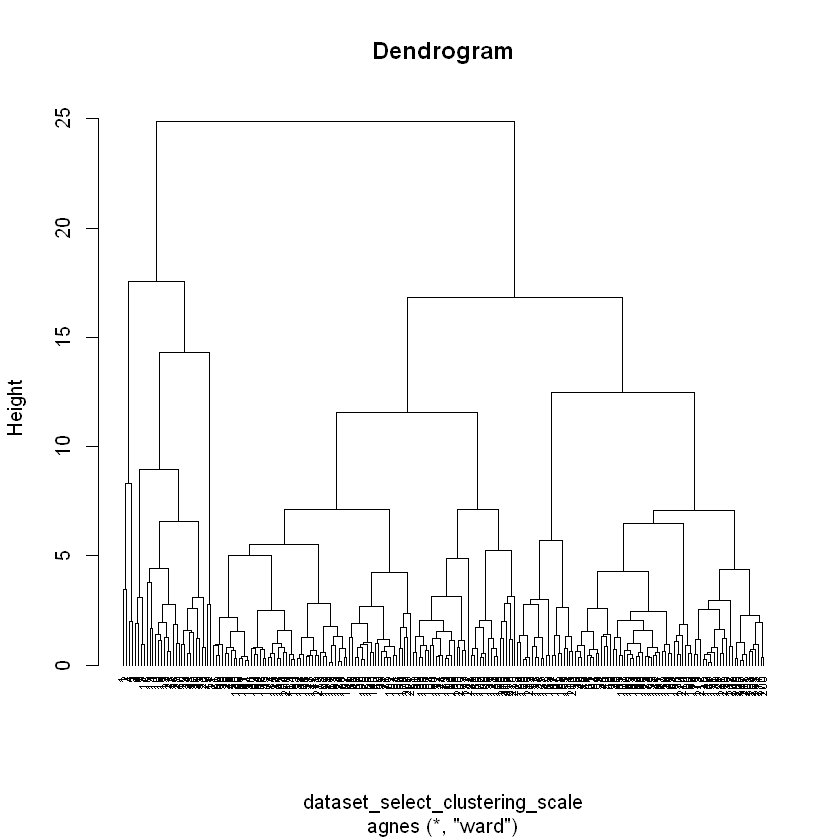

In [133]:
cluster <- agnes(dataset_select_clustering_scale, method = "ward")

#Viewing the clusters in a dendrogram
pltree(cluster, cex = 0.6, hang = -1, main = "Dendrogram") 

## Applying the Clusters to the original dataset

In [134]:
cluster <- hclust(dist(dataset_select_clustering_scale), method = "ward.D2")

## UnSupervised Cluster Evaluation

Here we are evaluating 4 different Cluster sizes , CLusters with cluster number 2,4,6,8 to identify which would be the best clustering

### Gap Statistics

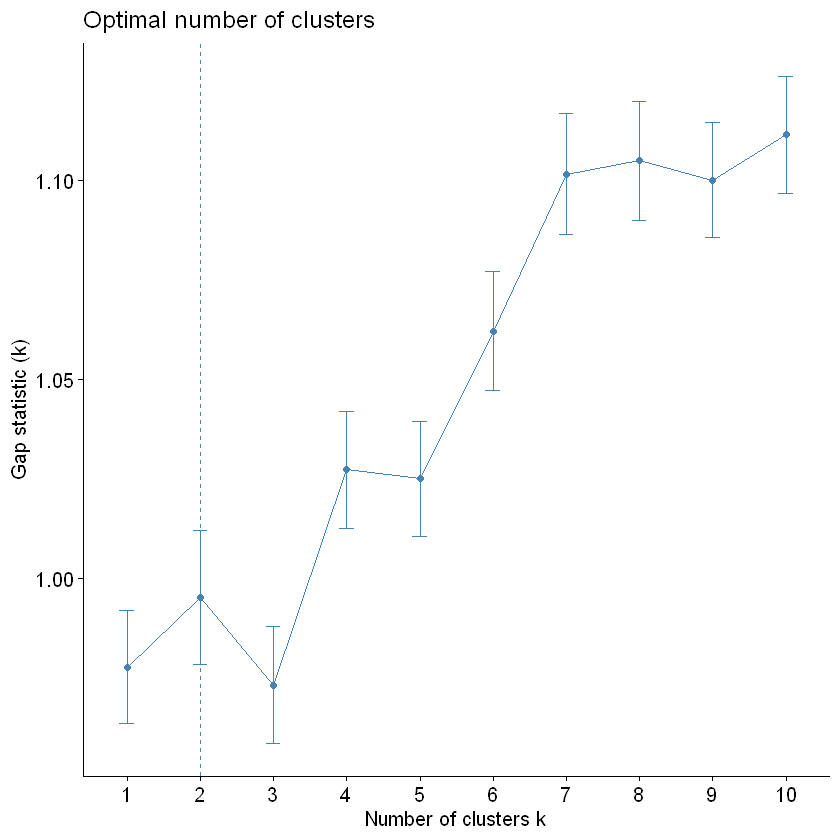

In [135]:
gap_stat <- clusGap(dataset_select_clustering_scale, FUN = hcut, nstart = 10,K.min=3, K.max = 10, B = 100)

#produce plot of clusters vs. gap statistic
fviz_gap_stat(gap_stat)

According to gap Statistics the optimal number of clusters is **2**.

### Silhouette Coefficient

In [136]:
dataset_hclust_results1 <- dataset_select_clustering
dataset_hclust_results2 <- dataset_select_clustering
dataset_hclust_results3 <- dataset_select_clustering
dataset_hclust_results4 <- dataset_select_clustering
dataset_hclust_results1$cluster <- cutree(cluster, 2)
dataset_hclust_results2$cluster <- cutree(cluster, 4)
dataset_hclust_results3$cluster <- cutree(cluster, 6)
dataset_hclust_results4$cluster <- cutree(cluster, 8)

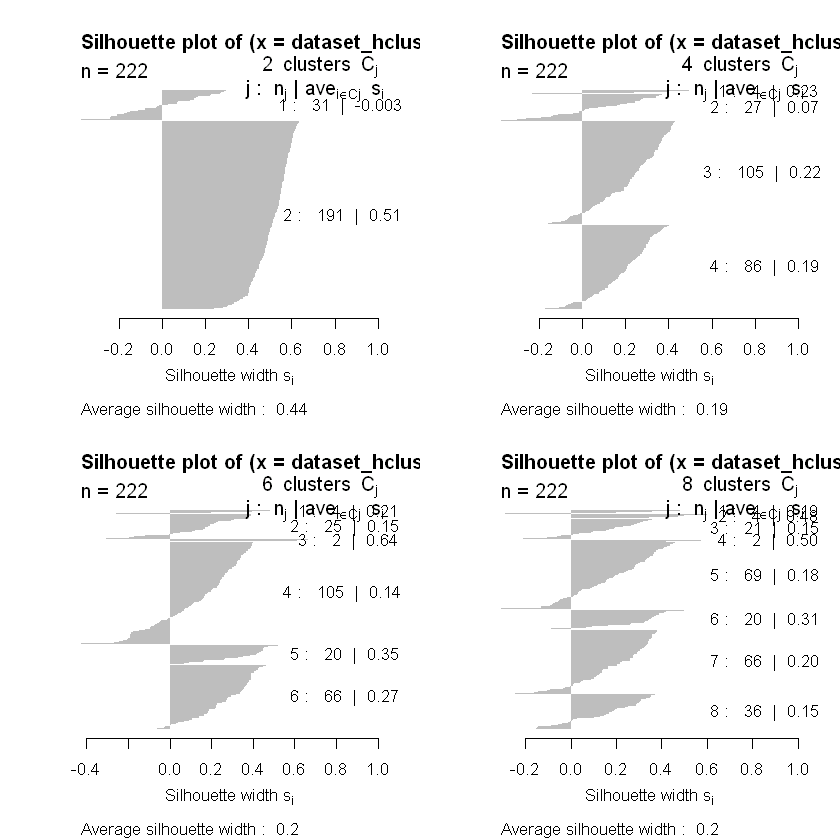

In [137]:
d <- dist(dataset_select_clustering_scale)

par(mfrow = c(2, 2))
plot(silhouette(dataset_hclust_results1$cluster, d))
plot(silhouette(dataset_hclust_results2$cluster, d))
plot(silhouette(dataset_hclust_results3$cluster, d))
plot(silhouette(dataset_hclust_results4$cluster, d))


From this Silhoette Plot also, We can infer that the **2 clusters have the maximum silohoette score**. 2 is the optimal number of clusters based on the selected features

## Visualizing the Clusters

#### The below table shows the mean values of each of the feature variables used for clustering

In [138]:
dataset_hclust_results <- dataset_hclust_results1
dataset_hclust_results %>% group_by(cluster) %>% summarize(
  avg_death_per_case = mean(death_per_case), 
    avg_median_age=mean(median_age),
    avg_median_income=mean(median_income),
    avg_commute_1000=mean(commute_1000),
    avg_black_pop=mean(black_pop*1000/total_pop),
    avg_white_pop=mean(white_pop*1000/total_pop),
    avg_hispanic_pop=mean(hispanic_pop*1000/total_pop),
    no_counties_in_cluster=n())


cluster,avg_death_per_case,avg_median_age,avg_median_income,avg_commute_1000,avg_black_pop,avg_white_pop,avg_hispanic_pop,no_counties_in_cluster
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.01952826,34.04194,49015.00,799.9042,110.36313,519.8909,331.7475,31
2,0.02737668,40.16073,47170.13,738.8050,50.63811,571.7030,355.7910,191


#### Corelation Plot of feature variables based in the cluster

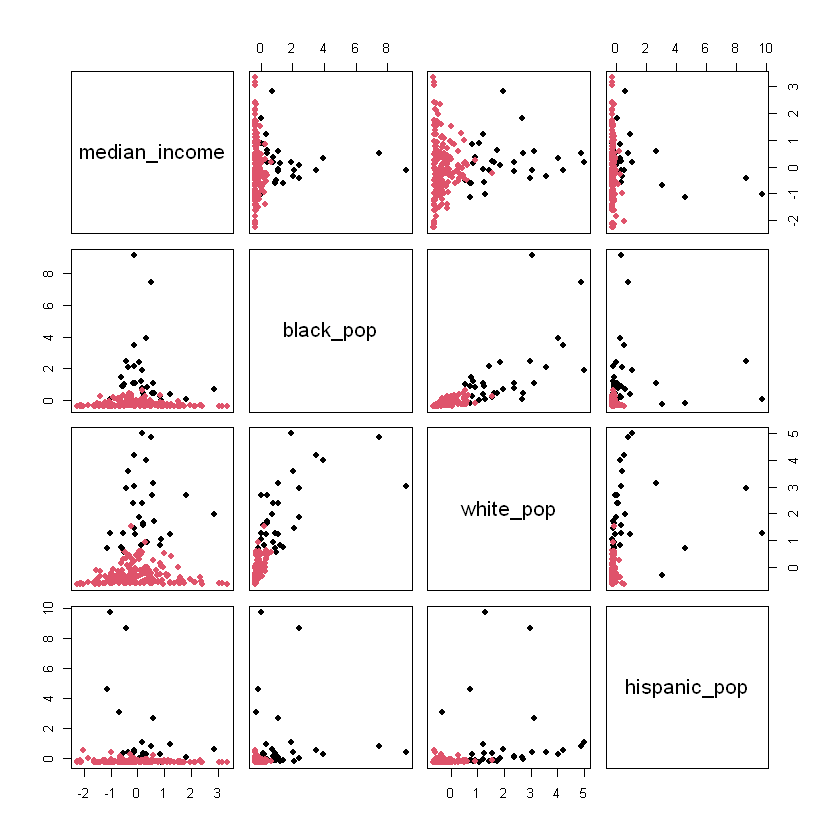

In [139]:
pairs(dataset_select_clustering_scale[,c("median_income","black_pop","white_pop","hispanic_pop")], 
      pch = 16, col = as.numeric(dataset_hclust_results$cluster))

#### PLotting the clusters over a map

In [140]:
counties <- as_tibble(map_data("county"))
counties_TX <- counties %>% dplyr::filter(region == "texas") %>% rename(c(county = subregion))


dataset_hclust_results <- dataset_hclust_results %>% mutate(county = county_name %>% str_to_lower() %>% 
    str_replace('\\s+county\\s*$', ''))
nrow(dataset_hclust_results)
nrow(counties_TX)
dataset_hclust_results_map<-right_join(dataset_hclust_results,counties_TX, join_by(county))

length(unique(dataset_hclust_results_map$county))
nrow(dataset_hclust_results_map)

[1] 222

[1] 4488

[1] 254

[1] 4488

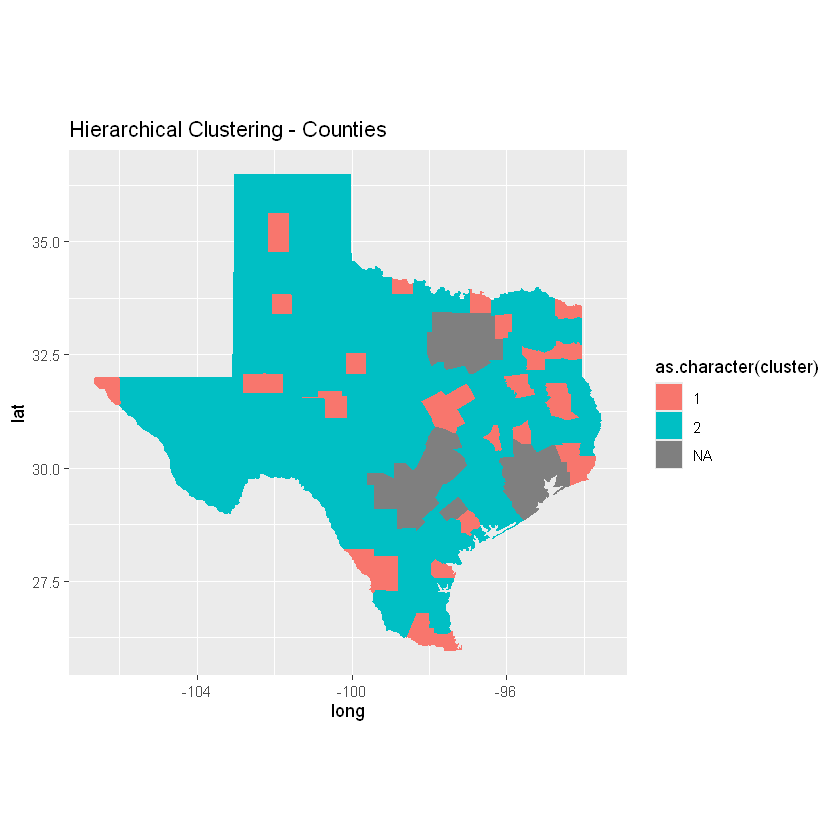

In [141]:
ggplot(dataset_hclust_results_map, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = as.character(cluster))) +
  coord_quickmap() +
  labs(title = "Hierarchical Clustering - Counties")

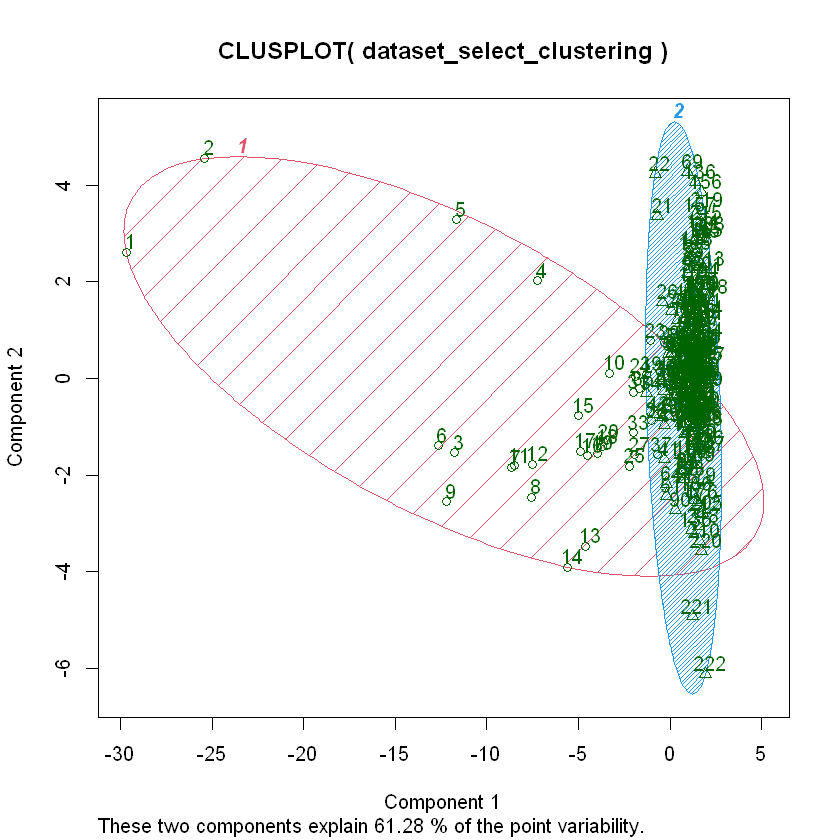

In [142]:
clusplot(dataset_select_clustering, dataset_hclust_results$cluster, color = TRUE, shade = TRUE, 
         labels = 2, lines = 0)

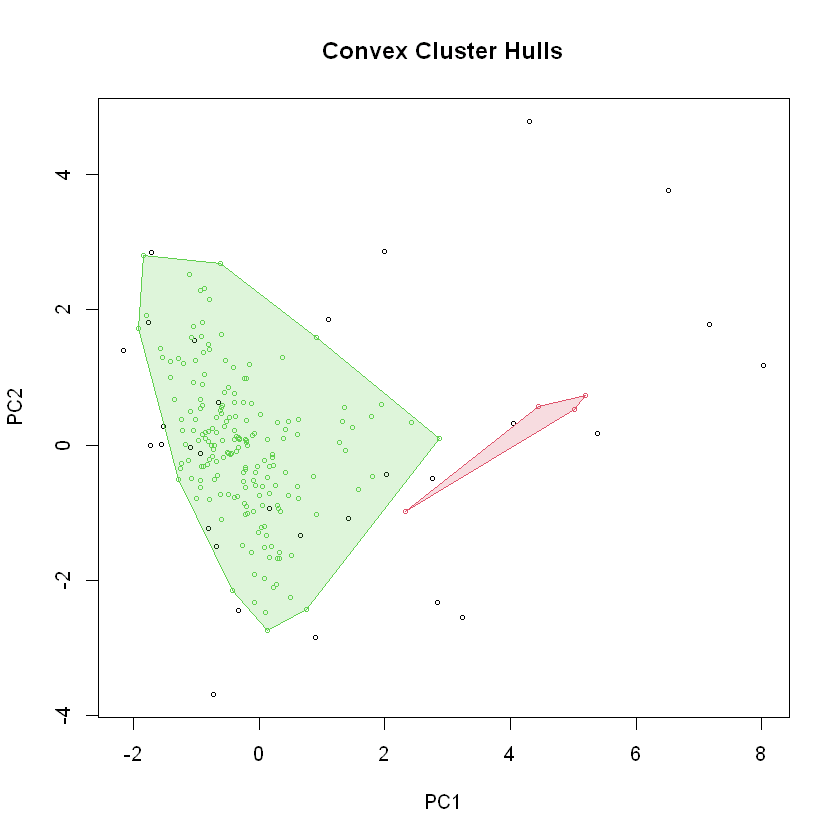

In [143]:
hullplot(dataset_select_clustering_scale, dataset_dbscan_results$cluster)


The non-colored counties are the metropolitan counties that were removed from the analysis

## Supervised Cluster evaluation

### Creating a ground truth feature to evaluate the cluster

In [144]:
ground_truth <- ifelse(dataset_hclust_results$death_per_case<=0.03961965, 1, 2)
table(ground_truth)

ground_truth
  1   2 
192  30 

### Evaluating the CLuster using the Purity Function

In [145]:


tbl <- table(dataset_hclust_results$cluster, ground_truth)
purity(dataset_hclust_results$cluster,ground_truth)

,ClassLabels,ClusterLabels,ClusterSize
,<chr>,<chr>,<dbl>
1,2,1,161


# Density Based Clustering 

In [146]:
library(dbscan)

In [147]:
dataset_select_clustering_scale <-scale(dataset_select_clustering[,c("income_100K_150K","commute_1000","worked_at_home_1000")])
summary(dataset_select_clustering_scale)

 income_100K_150K    commute_1000      worked_at_home_1000
 Min.   :-0.49239   Min.   :-2.81045   Min.   :-1.5283    
 1st Qu.:-0.43887   1st Qu.:-0.61096   1st Qu.:-0.5828    
 Median :-0.34345   Median : 0.09711   Median :-0.1320    
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000    
 3rd Qu.:-0.07254   3rd Qu.: 0.64486   3rd Qu.: 0.3213    
 Max.   : 7.37936   Max.   : 3.45757   Max.   : 4.8971    

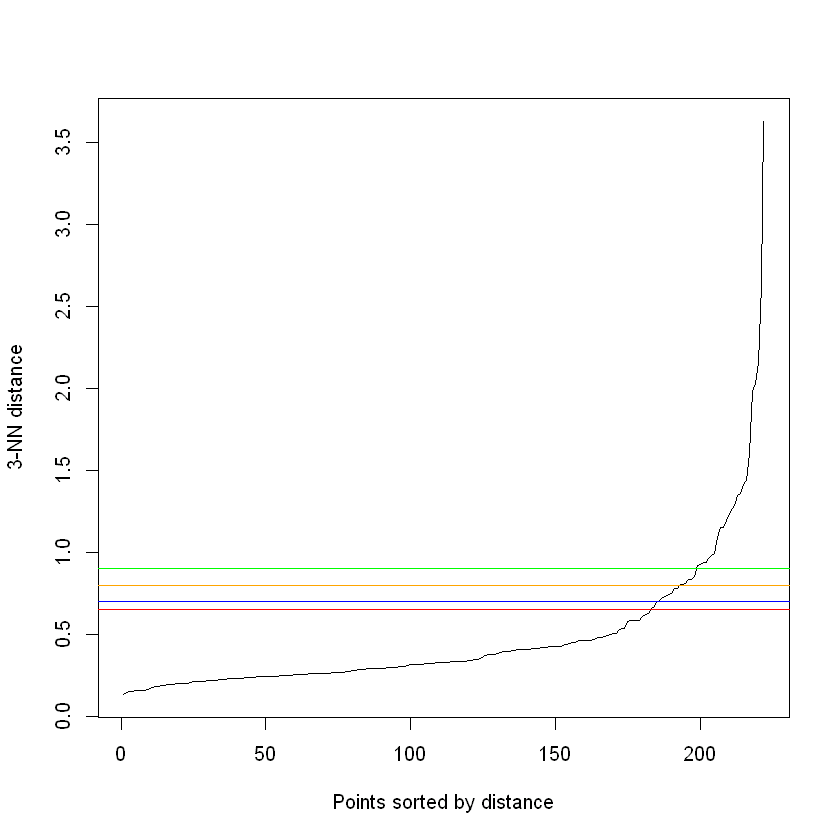

In [148]:
kNNdistplot(dataset_select_clustering_scale, minPts = 4)
abline(h = .65,col = "red")
abline(h = .7,col = "blue")
abline(h = .8,col = "orange")
abline(h = .9,col = "green")

In [149]:
dbcluster1 <- dbscan(dataset_select_clustering_scale, eps = .65, minPts = 4)
dbcluster1
dbcluster2 <- dbscan(dataset_select_clustering_scale, eps = .7, minPts = 4)
dbcluster2
dbcluster3 <- dbscan(dataset_select_clustering_scale, eps = .8, minPts = 4)
dbcluster3
dbcluster4 <- dbscan(dataset_select_clustering_scale, eps = .9, minPts = 4)
dbcluster4

DBSCAN clustering for 222 objects.
Parameters: eps = 0.65, minPts = 4
Using euclidean distances and borderpoints = TRUE
The clustering contains 2 cluster(s) and 30 noise points.

  0   1   2 
 30   4 188 

Available fields: cluster, eps, minPts, metric, borderPoints

DBSCAN clustering for 222 objects.
Parameters: eps = 0.7, minPts = 4
Using euclidean distances and borderpoints = TRUE
The clustering contains 2 cluster(s) and 27 noise points.

  0   1   2 
 27   4 191 

Available fields: cluster, eps, minPts, metric, borderPoints

DBSCAN clustering for 222 objects.
Parameters: eps = 0.8, minPts = 4
Using euclidean distances and borderpoints = TRUE
The clustering contains 2 cluster(s) and 20 noise points.

  0   1   2 
 20   4 198 

Available fields: cluster, eps, minPts, metric, borderPoints

DBSCAN clustering for 222 objects.
Parameters: eps = 0.9, minPts = 4
Using euclidean distances and borderpoints = TRUE
The clustering contains 2 cluster(s) and 16 noise points.

  0   1   2 
 16   4 202 

Available fields: cluster, eps, minPts, metric, borderPoints

In [150]:
dataset_dbscan_results1 <- dataset_select_clustering
dataset_dbscan_results1$cluster <- dbcluster1$cluster
dataset_dbscan_results2 <- dataset_select_clustering
dataset_dbscan_results2$cluster <- dbcluster2$cluster
dataset_dbscan_results3 <- dataset_select_clustering
dataset_dbscan_results3$cluster <- dbcluster3$cluster
dataset_dbscan_results4 <- dataset_select_clustering
dataset_dbscan_results4$cluster <- dbcluster4$cluster

## UnSupervised Cluster Evaluation

### Silhouette Coefficient

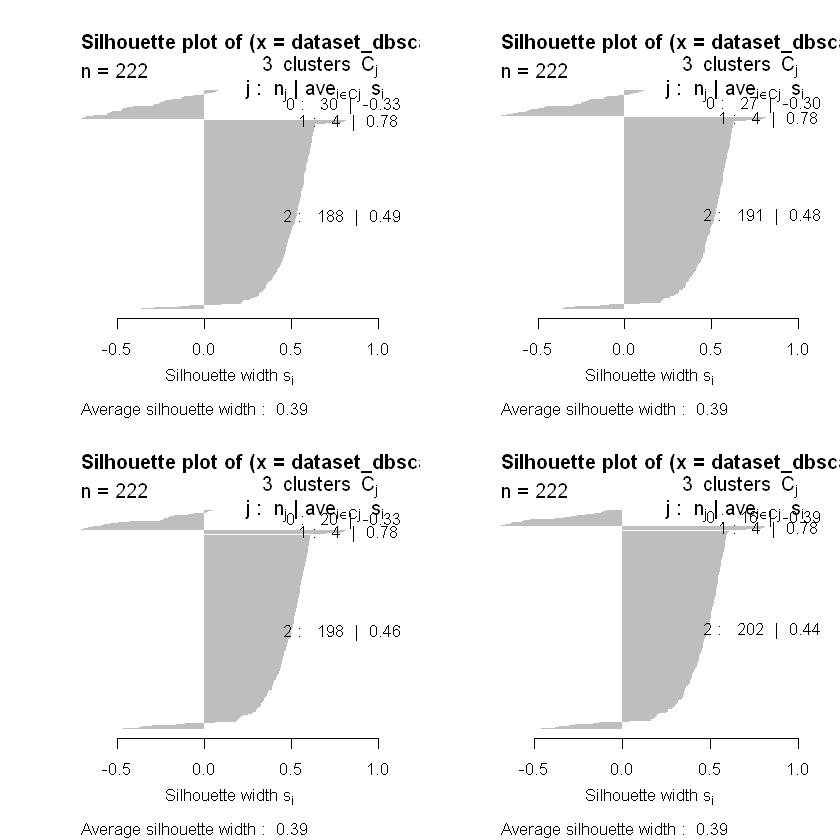

In [151]:
d <- dist(dataset_select_clustering_scale)

par(mfrow = c(2, 2))
plot(silhouette(dataset_dbscan_results1$cluster, d))
plot(silhouette(dataset_dbscan_results2$cluster, d))
plot(silhouette(dataset_dbscan_results3$cluster, d))
plot(silhouette(dataset_dbscan_results4$cluster, d))


THe first cluster has the highest Silohoette coefficient, Hence a better clustering

### Dunn Index

In [152]:
clValid::dunn(distance = dist(dataset_select_clustering_scale), dataset_dbscan_results1$cluster, method = "euclidean")

clValid::dunn(distance = dist(dataset_select_clustering_scale), dataset_dbscan_results2$cluster, method = "euclidean")
clValid::dunn(distance = dist(dataset_select_clustering_scale), dataset_dbscan_results3$cluster, method = "euclidean")
clValid::dunn(distance = dist(dataset_select_clustering_scale), dataset_dbscan_results4$cluster, method = "euclidean")

[1] 0.2006929

[1] 0.1952209

[1] 0.1926857

[1] 0.1818901

THe higher the Dunn Index, THe better the cluster. Hence Dunn Index also proves that **first Cluster  is a better clustering.**

## Visualizing the Cluster

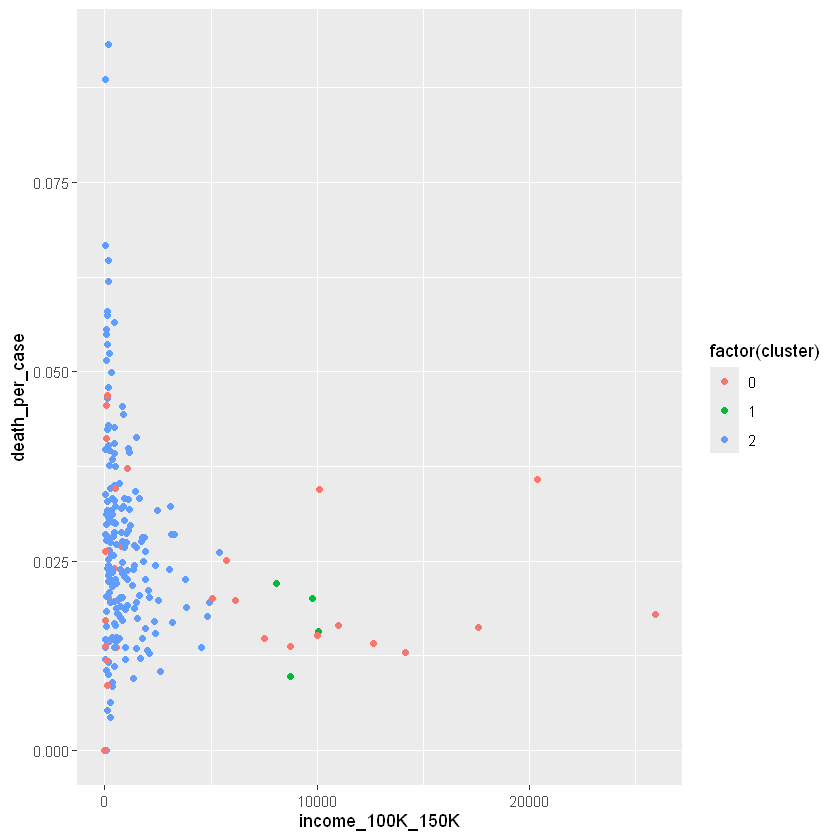

In [153]:
dataset_dbscan_results<- dataset_dbscan_results1
ggplot(dataset_dbscan_results, aes(x = income_100K_150K, y = death_per_case)) +
    geom_point(aes(color = factor(cluster)))

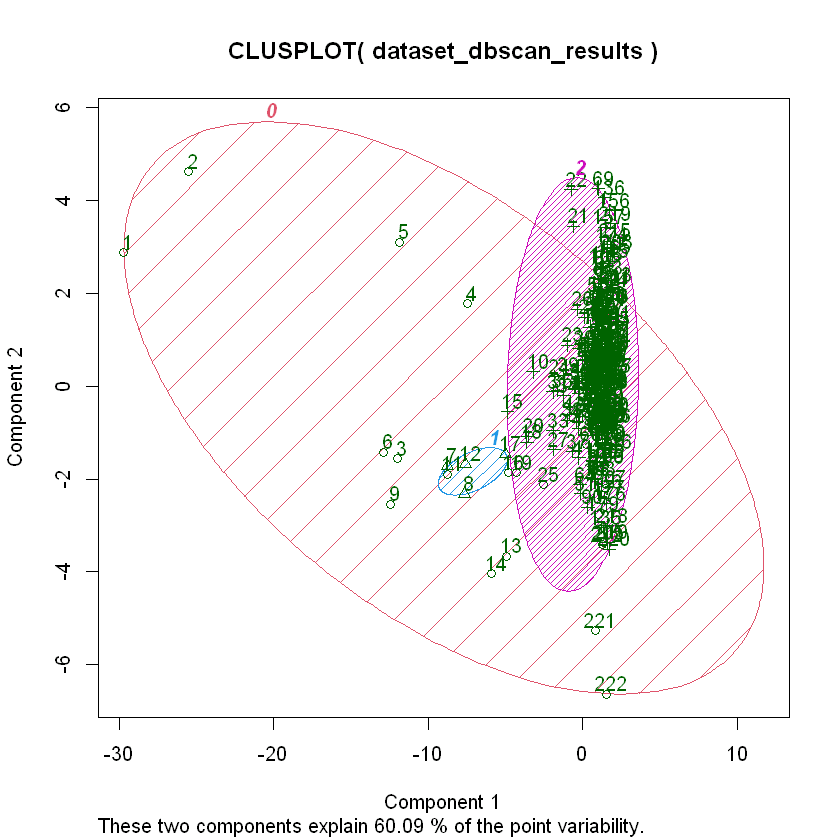

In [154]:
clusplot(dataset_dbscan_results, dataset_dbscan_results$cluster, color = TRUE, shade = TRUE, 
         labels = 2, lines = 0)

In [155]:
dataset_dbscan_results %>% group_by(cluster) %>% summarize(
  avg_death_per_case = mean(death_per_case), 
    avg_income_100K_150K=mean(income_100K_150K),
    avg_commute_1000=mean(commute_1000),
    avg_worked_at_home_1000=mean(worked_at_home_1000),
    no_counties_in_cluster=n())


cluster,avg_death_per_case,avg_income_100K_150K,avg_commute_1000,avg_worked_at_home_1000,no_counties_in_cluster
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0.02131105,5307.9667,772.6344,27.35287,30
1,0.01687944,9162.2500,848.0232,14.30697,4
2,0.02727379,872.9574,741.1578,13.69180,188


### Plotting the Cluster over a Texas Map

In [156]:

counties <- as_tibble(map_data("county"))
counties_TX <- counties %>% dplyr::filter(region == "texas") %>% rename(c(county = subregion))

dataset_dbscan_results <- dataset_dbscan_results %>% mutate(county = county_name %>% str_to_lower() %>% 
    str_replace('\\s+county\\s*$', ''))
nrow(dataset_dbscan_results)
nrow(counties_TX)
dataset_dbscan_results_map<-right_join(dataset_dbscan_results,counties_TX, join_by(county))


[1] 222

[1] 4488

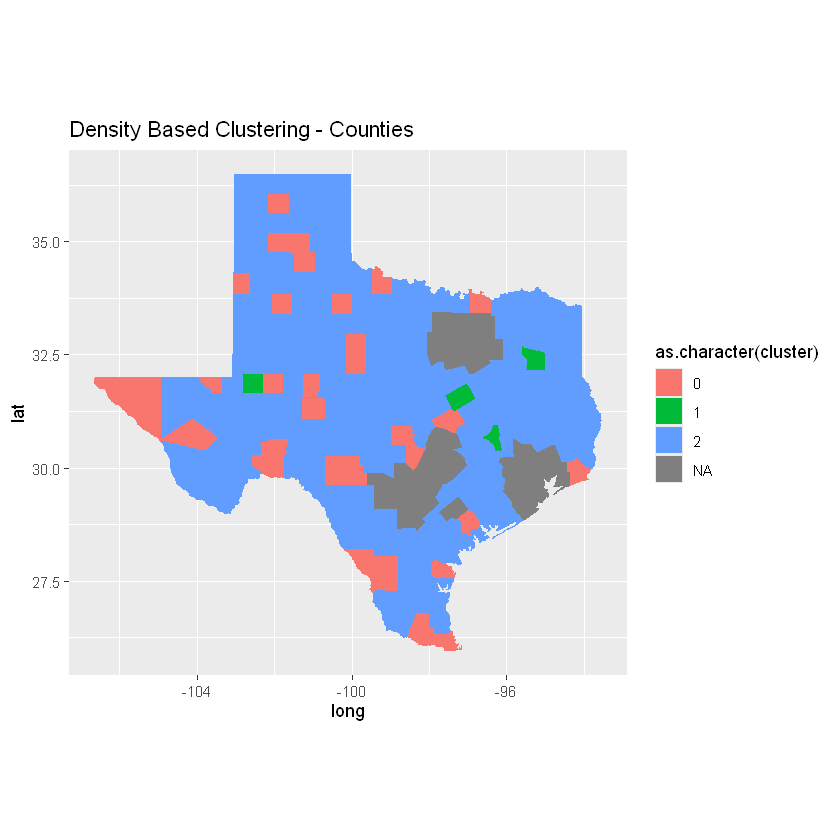

In [157]:
ggplot(dataset_dbscan_results_map, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = as.character(cluster))) +
  coord_quickmap() +
  labs(title = "Density Based Clustering - Counties")

# Fuzzy Custering

In [158]:

dataset_select_clustering_scale <-scale(dataset_select_clustering[,c("median_age","commute_1000","median_income")])
summary(dataset_select_clustering_scale)

   median_age        commute_1000      median_income    
 Min.   :-2.20750   Min.   :-2.81045   Min.   :-2.2682  
 1st Qu.:-0.75695   1st Qu.:-0.61096   1st Qu.:-0.5904  
 Median :-0.01737   Median : 0.09711   Median :-0.1018  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.64865   3rd Qu.: 0.64486   3rd Qu.: 0.4878  
 Max.   : 2.97362   Max.   : 3.45757   Max.   : 3.3582  

In [159]:
set.seed(123) 
n_cluster <- 5 
m <- 2 
fuzzy_cluster1 <- cmeans(dataset_select_clustering_scale, centers = 5, m = m)
fuzzy_cluster2 <- cmeans(dataset_select_clustering_scale, centers = 3, m = m)
fuzzy_cluster3 <- cmeans(dataset_select_clustering_scale, centers = 7, m = m)
fuzzy_cluster4 <- cmeans(dataset_select_clustering_scale, centers = 9, m = m)

In [160]:
# Data Membership Degree Matrix 
fuzzy_membership_matrix1 <- fuzzy_cluster1$membership 
fuzzy_membership_matrix2 <- fuzzy_cluster2$membership 
fuzzy_membership_matrix3 <- fuzzy_cluster3$membership 
fuzzy_membership_matrix4 <- fuzzy_cluster4$membership 
  
# Cluster Prototype Evolution Matrices 
initial_centers1 <- fuzzy_cluster1$centers 
final_centers1 <- t(fuzzy_cluster1$centers)

initial_centers2 <- fuzzy_cluster2$centers 
final_centers2 <- t(fuzzy_cluster2$centers)

initial_centers3 <- fuzzy_cluster3$centers 
final_centers3 <- t(fuzzy_cluster3$centers)

initial_centers4 <- fuzzy_cluster4$centers 
final_centers4 <- t(fuzzy_cluster4$centers)

In [161]:
cluster_membership1 <- as.data.frame(fuzzy_cluster1$membership) 
cluster_membership2 <- as.data.frame(fuzzy_cluster2$membership) 
cluster_membership3 <- as.data.frame(fuzzy_cluster3$membership) 
cluster_membership4 <- as.data.frame(fuzzy_cluster4$membership) 

fuzzy_cluster_data1 <- cbind(dataset_select_clustering_scale, cluster_membership1) 
fuzzy_cluster_data2 <- cbind(dataset_select_clustering_scale, cluster_membership2) 
fuzzy_cluster_data3 <- cbind(dataset_select_clustering_scale, cluster_membership3) 
fuzzy_cluster_data4 <- cbind(dataset_select_clustering_scale, cluster_membership4) 

head(fuzzy_cluster_data1)

,median_age,commute_1000,median_income,1,2,3,4,5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.2105034,0.2822249,-0.4192664,0.5741742,0.06299800,0.1418649,0.08390089,0.13706198
2,-1.7008301,-0.9267076,-1.0352764,0.1489312,0.07609592,0.1202506,0.06037085,0.59435139
3,-1.4066341,1.6069950,0.1653769,0.4407787,0.07708187,0.1318228,0.26717510,0.08314157
4,-1.7825512,-0.4077678,-0.7000635,0.2661003,0.08719421,0.1546012,0.09085855,0.40124578
5,-1.2922245,-0.6418784,-1.1356899,0.1327448,0.06667988,0.1116178,0.04551595,0.64344156
6,-0.6874882,1.1234250,0.5901803,0.4232509,0.04457033,0.0905769,0.40596213,0.03563971


## Un Supervised Cluster Evaluation

### Davies-Bouldin index 

In [162]:
# Function to calculate the Davies-Bouldin index 
davies_bouldin_index <- function(data, cluster_centers, membership_matrix) { 
require(cluster) 

num_clusters <- nrow(cluster_centers) 
scatter <- numeric(num_clusters) 
for (i in 1:num_clusters) { 
	scatter[i] <- mean(sqrt(rowSums((data - cluster_centers[i,])^2)) * membership_matrix[i,]) 
} 

# Calculate the cluster separation 
separation <- matrix(0, nrow = num_clusters, ncol = num_clusters) 
for (i in 1:num_clusters) { 
	for (j in 1:num_clusters) { 
	if (i != j) { 
		separation[i, j] <- sqrt(sum((cluster_centers[i,] - cluster_centers[j,])^2)) 
	} 
	} 
} 

# Calculate the Davies-Bouldin index 
db_index <- 0 
for (i in 1:num_clusters) { 
	max_val <- -Inf
	for (j in 1:num_clusters) { 
	if (i != j) { 
		val <- (scatter[i] + scatter[j]) / separation[i, j] 
		if (val > max_val) { 
		max_val <- val 
		} 
	} 
	} 
	db_index <- db_index + max_val 
} 
db_index <- db_index / num_clusters 
return(db_index) 
} 


In [163]:
# Example usage of the Davies-Bouldin index function 
db_index <- davies_bouldin_index(fuzzy_cluster_data1, fuzzy_cluster1$centers, fuzzy_membership_matrix1) 
print(paste("Davies-Bouldin Index 1:", db_index))
db_index <- davies_bouldin_index(fuzzy_cluster_data2, fuzzy_cluster2$centers, fuzzy_membership_matrix2) 
print(paste("Davies-Bouldin Index 2:", db_index))
db_index <- davies_bouldin_index(fuzzy_cluster_data3, fuzzy_cluster3$centers, fuzzy_membership_matrix3) 
print(paste("Davies-Bouldin Index 3:", db_index))
db_index <- davies_bouldin_index(fuzzy_cluster_data4, fuzzy_cluster4$centers, fuzzy_membership_matrix4) 
print(paste("Davies-Bouldin Index 4:", db_index))

Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"


[1] "Davies-Bouldin Index 1: 0.827451929884809"
[1] "Davies-Bouldin Index 2: 0.962752302320374"


Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i,

[1] "Davies-Bouldin Index 3: 0.638696519668135"


Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i, ])^2)) * membership_matrix[i, :
"longer object length is not a multiple of shorter object length"
Warning message in sqrt(rowSums((data - cluster_centers[i,

[1] "Davies-Bouldin Index 4: 0.641657463393572"


## Displaying the Clusters

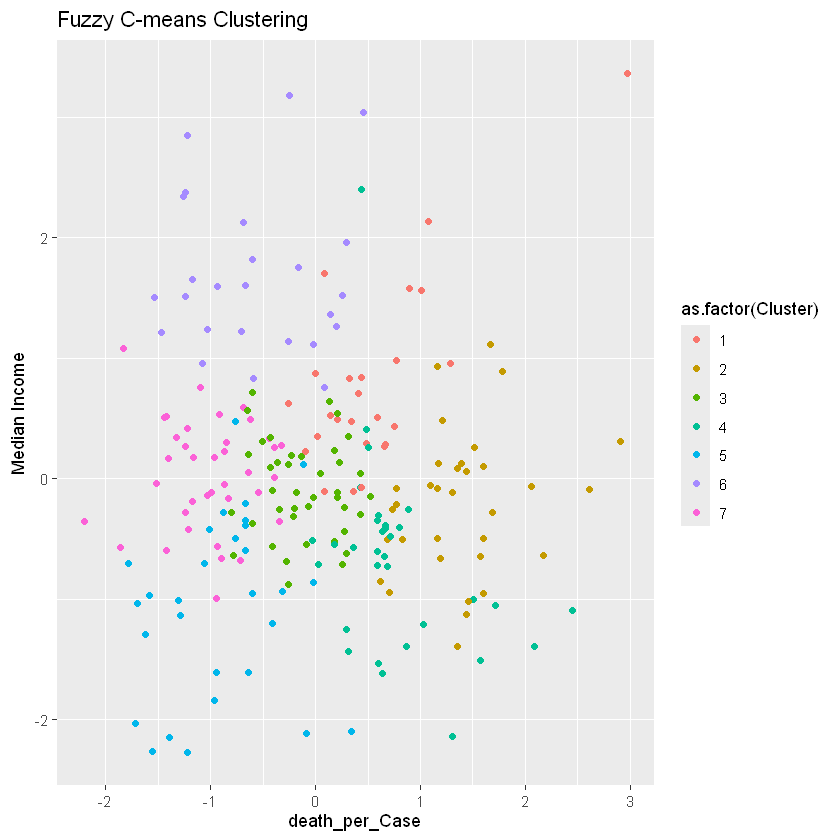

In [164]:

fuzzy_cluster_data <- fuzzy_cluster_data3
fuzzy_cluster <- fuzzy_cluster3
fuzzy_membership_matrix <- fuzzy_membership_matrix3

centers <- t(fuzzy_cluster$centers) 
fuzzy_cluster_data$Cluster <- apply(fuzzy_membership_matrix, 1, which.max) 
ggplot(fuzzy_cluster_data, aes(x = median_age, y = median_income,  
                               color = as.factor(Cluster))) + 
  geom_point() + 
  labs(title = "Fuzzy C-means Clustering", x = "death_per_Case", y = "Median Income")

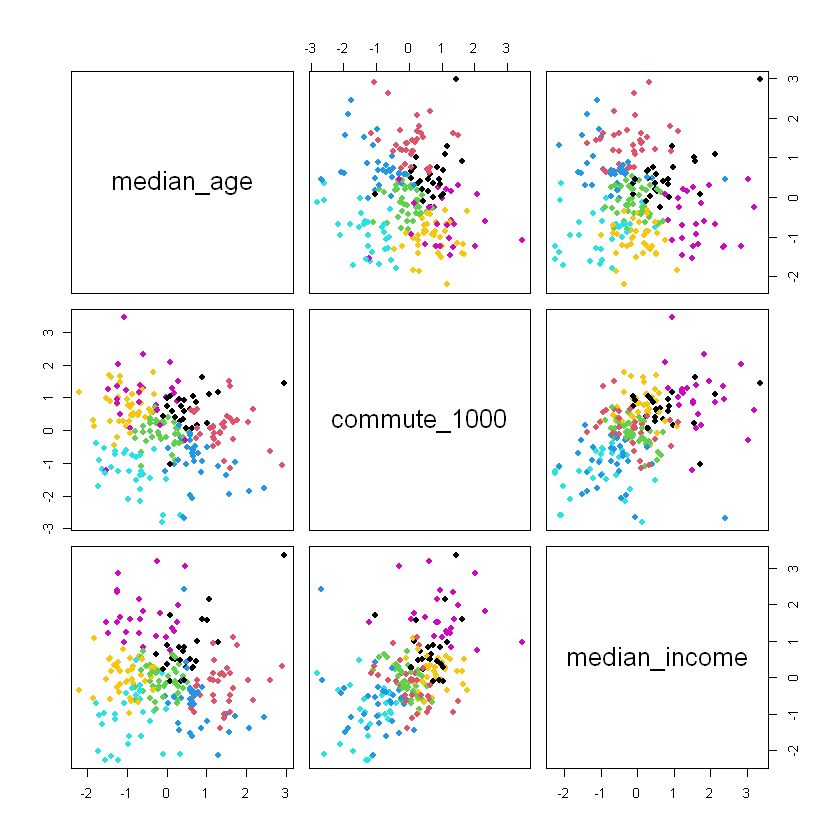

In [165]:
pairs(dataset_select_clustering_scale, pch = 16, col = as.numeric(fuzzy_cluster$cluster))

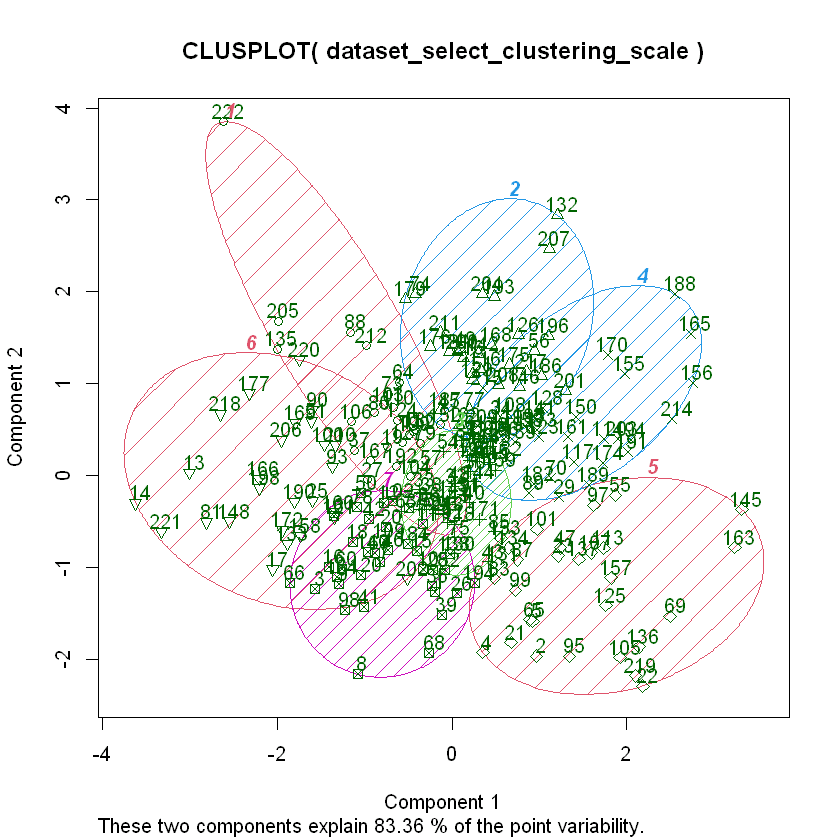

In [166]:
clusplot(dataset_select_clustering_scale, fuzzy_cluster$cluster, color = TRUE, shade = TRUE, 
         labels = 2, lines = 0)

From the above, We can see that most of the features used for the data set has fair amount of corelation

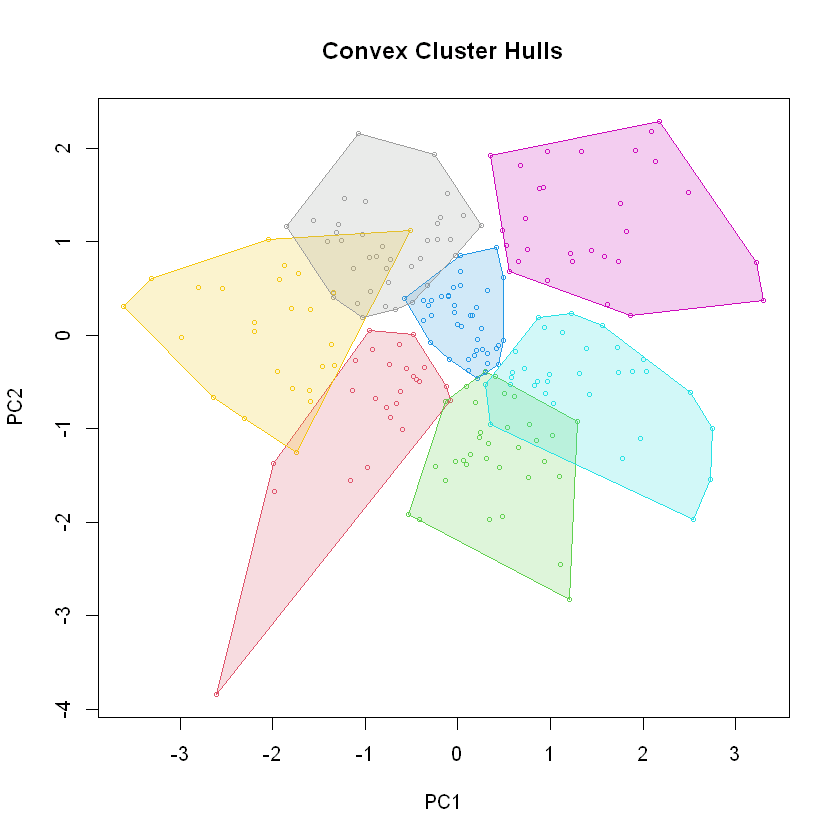

In [167]:
hullplot(dataset_select_clustering_scale, fuzzy_cluster$cluster)

In [168]:
dataset_select_clustering$cluster <- fuzzy_cluster$cluster

In [169]:
dataset_select_clustering %>% group_by(cluster) %>% summarize(
  avg_death_per_case = mean(death_per_case),
    avg_cases_per_1000 = mean(cases_per_1000),
    avg_median_age=mean(median_age),
    avg_median_income=mean(median_income),
    avg_wcommute_1000=mean(commute_1000),
    no_counties_in_cluster=n())

cluster,avg_death_per_case,avg_cases_per_1000,avg_median_age,avg_median_income,avg_wcommute_1000,no_counties_in_cluster
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.02173999,64.82323,42.64800,55292.60,811.6238,25
2,0.02837187,71.40581,47.79091,45314.24,754.4016,33
3,0.02978863,80.03636,38.58500,46486.03,741.8564,40
4,0.03063572,63.95241,44.05625,40662.38,646.6498,32
5,0.02551958,99.12977,33.79655,36789.21,617.0637,29
6,0.02118317,75.78486,35.70400,64151.52,853.5330,25
7,0.02402670,92.12683,33.07368,47893.76,819.0189,38


## Supervised Cluster evaluation

### Creating the ground truth

We are creating the ground truth by dividing the death percentage to 7 groups based on the descending order of the confirmed cases

In [170]:
ground_truth <- ntile(dataset_select_clustering$death_per_case, 7)
table(ground_truth)

ground_truth
 1  2  3  4  5  6  7 
32 32 32 32 32 31 31 

### Purity evaluation based on the ground truth

In [171]:
tbl <- table(fuzzy_cluster$cluster, ground_truth)
purity(fuzzy_cluster$cluster,ground_truth)

,ClassLabels,ClusterLabels,ClusterSize
,<chr>,<chr>,<dbl>
7,1,5,2
4,2,6,9
1,3,3,11
2,4,7,10
6,5,2,8
3,6,1,9
5,7,4,8


# References

https://www.statology.org/hierarchical-clustering-in-r/ <br>
https://www.geeksforgeeks.org/fuzzy-clustering-in-r/  <br>
https://uc-r.github.io/hc_clustering  <br>
https://www.geeksforgeeks.org/dbscan-clustering-in-r-programming/ <br>
https://www.geeksforgeeks.org/dunn-index-and-db-index-cluster-validity-indices-set-1/
